# Time Series Forecasting on Climate Data

Climate change is real, and I am passionate about moving towards a more sustainable future. A future where we can live in harmony with animals and plants, without detsroying their habitat. At the current rate, we have only a few years before we can reverse the adverse effects of climate change that we are now seeing today. 

There are uncontrollable fires in Australia, California and Uttarakhand. There are unprecendented floods in Florida, Kerela and Ethiopia. There is a new trans-atlantic route that has opened from Europe to Canada because of the sheer amount of ice that has melted in the past few decades. We have already crossed 400 ppm of Carbon in the atmosphere and if nothing is done soon, we will have passed the point of no return.

So, that's the general objective of this project, to build a neural network that can accurately capture the cycles, trends and seasonality in the climate data. I have tried to implement a relatively simple Recurrent Neural Network (RNN) to forecast the weather.

Let's first start by importing all the necessary libraries that we will be making use of through the course of this project.

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. 

Fortunately for us, the dataset is available to us as part of TensorFlow datasets.

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Let us now explore the data a little bit by having a look at it.

In [3]:
df = pd.read_csv(csv_path)

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


The Date Time column seems to be in the expected format so that will be good when we start doing the time-series analysis with other variables.

As you can see above, an observation is recorded every 10 minutes. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations.

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function ``univariate_data`` returns the above described windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    
    return np.array(data), np.array(labels)

We have close to 2100 days worth of data, so we will be using first 300000 rows as training and the rest as validation. Let us also set the seed for reproducibility.

In [5]:
TRAIN_SPLIT = 300000

tf.random.set_seed(13)

# Forecasting a Univariate Time Series

First, let us build a simple model on ``normalized / standadized`` data. From my past experience, normalized data always performs better in a time-series setting. We will train the model only based on the `T (degC)` or `temperature` attribute and make prediction into the future based on this. 

Date Time will be set as an index.

In [6]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Great! We have the data that we need. Visualizing it might give us some perspective. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A737C8A4A8>],
      dtype=object)

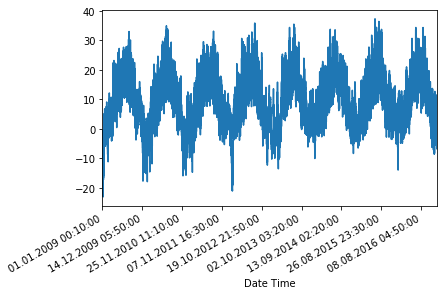

In [7]:
uni_data.plot(subplots = True)

As expected, temperature has a clear seasonal trend. Normalizing the data below.

# Data Normalization

In [8]:
uni_data = uni_data.values

In [9]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

Data is now normalized and it's time to use the `univariate_data` function that we took so long to figure out the logic for. The function will take last 20 recorded temperature and observations and would need to learn and predict the temperature at the next time step.

In [10]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [11]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [12]:
def create_time_steps(length):
    return list(range(-length, 0))

Below is the code that I have taken from one of the Stack Overflow posts which is used to plot a time-series data.

In [13]:
def show_plot(plot_data, delta, title):
  
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize = 10,
                  label = labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

Visualizing the training data, we see how diffuclt it is going to be for a DNN (or an RNN in our case) to accurately predict on this highly variable data.

<module 'matplotlib.pyplot' from 'C:\\Users\\shiiv\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

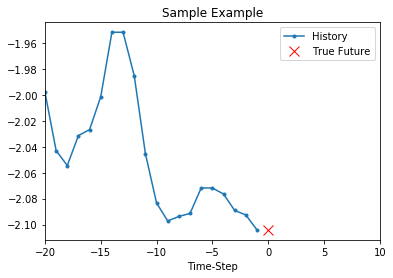

In [14]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

The `baseline` function just gives the average of the array that is fed to it, hence the term 'baseline'!

In [15]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\shiiv\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

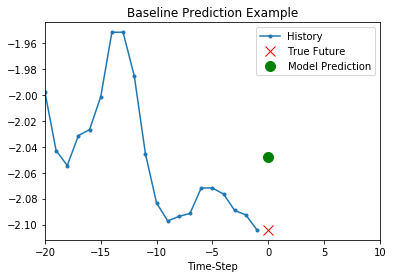

In [16]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

And here we see how terribly our baseline model does at capturing the seasonality in our data. I hope our RNN model can do better than this!

# Recurrent Neural Network

I have set the batch size to 256, so we will have only 256 batches at any point in the training set and a buffer size of 10000. First, we will build a pipeline with the data that we already have in the `x_train_uni` and `y_train_uni` variables which consist of our univariate data.

Then, we will use `shuffle`, for example, dataset.shuffle(buffer_size=3) will allocate a buffer of size 3 for picking random entries. This buffer will be connected to the source dataset.

As soon as all the entries are read from the dataset and you try to read the next element, the dataset will throw an error. That's where `dataset.repeat()` comes into play. It will re-initialize the dataset.

The `dataset.batch()` will take first batch_size entries and make a batch out of them.

In [17]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Now that we have our data pre-processed and organized in the way we want, next comes the interesting part where we get to train our data using a very simple RNN.

The RNN layer will have just 8 neurons and one output neuron which will store the final value. The input shape will be (20, 0). We will be making use of the `adam` optimizer and keep `mean absolute error (mae)` as our loss metric.

In [44]:
simple_lstm_model = tf.keras.models.Sequential([
    
    tf.keras.layers.LSTM(100, input_shape = x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer = 'adam', loss = 'mae')

It's time to see how the RNN model compares to our baseline model. We will train on 200 examples and test on 50, running it for 10 epochs to see if the loss is decreasing over tiem or not.

In [45]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs = EPOCHS,
                      steps_per_epoch = EVALUATION_INTERVAL,
                      validation_data = val_univariate, validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 109s 546ms/step - loss: 0.0871 - val_loss: 0.0323
Epoch 2/10
200/200 [==============================] - 102s 509ms/step - loss: 0.0358 - val_loss: 0.0268
Epoch 3/10
200/200 [==============================] - 100s 501ms/step - loss: 0.0318 - val_loss: 0.0223
Epoch 4/10
200/200 [==============================] - 104s 520ms/step - loss: 0.0262 - val_loss: 0.0193
Epoch 5/10
200/200 [==============================] - 96s 480ms/step - loss: 0.0214 - val_loss: 0.0178
Epoch 6/10
200/200 [==============================] - 96s 480ms/step - loss: 0.0234 - val_loss: 0.0182
Epoch 7/10
200/200 [==============================] - 95s 477ms/step - loss: 0.0204 - val_loss: 0.0168
Epoch 8/10
200/200 [==============================] - 96s 480ms/step - loss: 0.0198 - val_loss: 0.0152
Epoch 9/10
200/200 [==============================] - 92s 458ms/step - loss: 0.0195 - val_loss: 0.0182
Epoch 10/10
200/200 [=====

From the output above, we can clearly see that there is a significant decrease in both training and validation loss. Maybe predicting on the validation data for 2-3 cases and seeing the predictions will give us a betetr idea if or not this model is doing better than our baseline estimate.

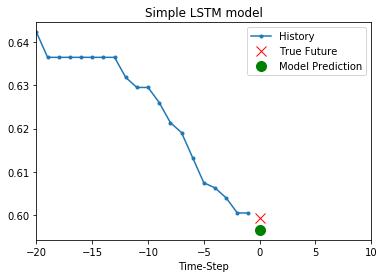

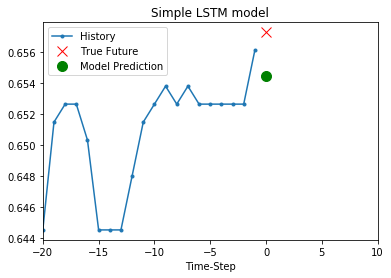

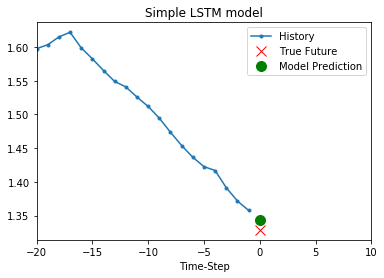

In [51]:
for x, y in val_univariate.take(3):
      plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
      plot.show()

We can clearly see that the predictions made by our model are way better than our baseline model, so that's a good start. We can make more complex RNN models now and even try our hands on **Multivariate Time-Series**.

# Forecasting a Multivariate Time-Series

In this section, we will be repeating most of the steps we have already done but we will use more variables, not just temperature for our model. We will include pressure and rho, which is the density of air index.

In [21]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

Similar to how we defined the univariate series, we will extract the values for our multivariate series.

In [22]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


All is set! Let's plot the graphs for the selected features to see if there are is any seasonality or cycle to our features.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A741694F60>,
      dtype=object)

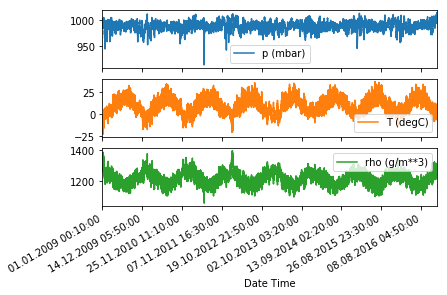

In [23]:
features.plot(subplots = True)

Looks like all our features are seasonal and have some cyclicity as well.

In [24]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis = 0)
data_std = dataset[:TRAIN_SPLIT].std(axis = 0)

Let us now normalize the data.

In [25]:
dataset = (dataset-data_mean)/data_std

# Single Step Model

Here, we will have to define a function which will be very similar to the `univariate_data` function which we defined earlier. However, we have more features this time and need to make changes accordingly. 

In [26]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step = False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

Here, we will take more number of observations in our data than before as we want a better prediction. 720 samples (last 5 days) are taken into consideration in each step. Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72 (12 x 6) observations is used.

In [27]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step = True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step = True)

Below, we see that there are 120 observations in any given window with three of our selected features.

In [28]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


We will use `shuffle`, for example, dataset.shuffle(buffer_size=3) will allocate a buffer of size 3 for picking random entries. This buffer will be connected to the source dataset.

As soon as all the entries are read from the dataset and you try to read the next element, the dataset will throw an error. That's where `dataset.repeat()` comes into play. It will re-initialize the dataset.

The `dataset.batch()` will take first batch_size entries and make a batch out of them.

In [29]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

We will build a similar model like last time, but use LSTM with `RMSprop` optimizer this time. Let's see what we get.

In [49]:
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(8,
                                           input_shape = x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss = 'mae')

Train on 200 samples, validate on 50. Just like how we did it last time.

In [50]:
single_step_history = single_step_model.fit(train_data_single, epochs = EPOCHS,
                                            steps_per_epoch = EVALUATION_INTERVAL,
                                            validation_data = val_data_single,
                                            validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 40s 199ms/step - loss: 0.4567 - val_loss: 0.3230
Epoch 2/10
200/200 [==============================] - 34s 168ms/step - loss: 0.3591 - val_loss: 0.2729
Epoch 3/10
200/200 [==============================] - 37s 185ms/step - loss: 0.3108 - val_loss: 0.2620
Epoch 4/10
200/200 [==============================] - 37s 185ms/step - loss: 0.2907 - val_loss: 0.2446
Epoch 5/10
200/200 [==============================] - 39s 196ms/step - loss: 0.2453 - val_loss: 0.2399
Epoch 6/10
200/200 [==============================] - 42s 210ms/step - loss: 0.2577 - val_loss: 0.2538
Epoch 7/10
200/200 [==============================] - 34s 172ms/step - loss: 0.2591 - val_loss: 0.2511
Epoch 8/10
200/200 [==============================] - 32s 158ms/step - loss: 0.2578 - val_loss: 0.2509
Epoch 9/10
200/200 [==============================] - 42s 209ms/step - loss: 0.2662 - val_loss: 0.2475
Epoch 10/10
200/200 [=========

Below is a custom function that I have taken form Stack Overflow to plot the `loss` journey through epochs. It is expected to get lower as epochs increase.

In [32]:
def plot_train_history(history, title):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

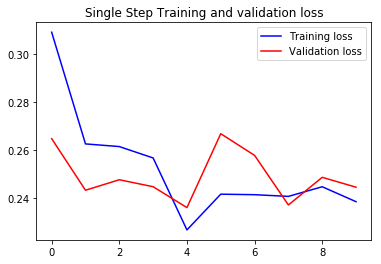

In [33]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

Clearly, training loss and validatoion loss are decreasing in harmony and it doesn't look like we are overfitting. Plotting the predictions on the validation set gives us decent results, given that our feature set has increased from just temperature to include temperature, pressure and air density as well.

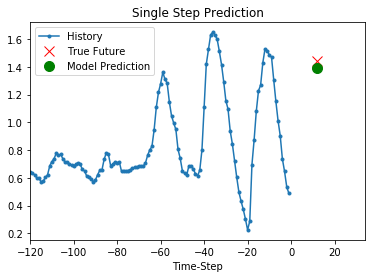

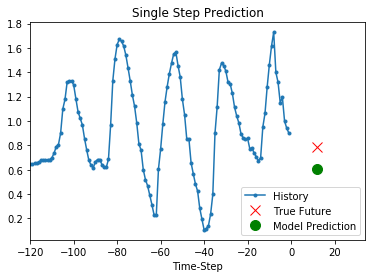

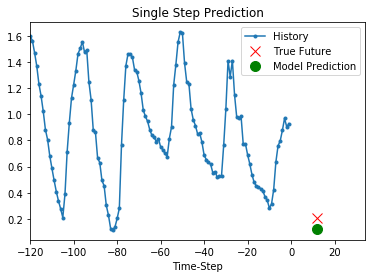

In [34]:
for x, y in val_data_single.take(3):
  
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

On we move towards a mul-step model! 

# Multi Step Model

Here, we will make use of the same function we defined for our single step model `multivariate_data`, but use `STEP = False` to show that this is not a **single-step model**, but a **multi-step one**.

The `future_target` variable is initialized with 72, as that's the amount of predictions that we want to make into the immediate future. Everything else is similar to what we have already seen. 

In [35]:
future_target = 72

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [36]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


Great! The shapes of the input and output arrays are as we want them to be. We can now use some random shiffling, based on batch size and repetition to make a non-biased dataset.

In [37]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Below is the plot function which has been modified from `single_step_plot` function to accomodate for more features. It does the exact same thing though.

In [38]:
def multi_step_plot(history, true_future, prediction):
  
  plt.figure(figsize = (12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label = 'History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label = 'True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label = 'Predicted Future')
  
  plt.legend(loc = 'upper left')
  plt.show()

Let's now have a glimpse into the **True Future** of the data. 120 observations into the future, to be precise.

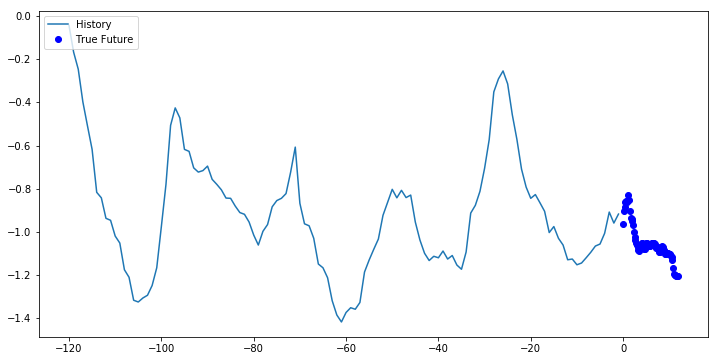

In [39]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Nice, the function seems to be doing it's job. Now, we make the model again, but with **two LSTM layers** this time. We will keep the number of neurons to 32 and 16 for this as I don't want to fry my GPU (lol). Also, looks like RMSprop gave us a better result than adam, so we'll go with that again.

In [40]:
multi_step_model = tf.keras.models.Sequential()

multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences = True,
                                          input_shape = x_train_multi.shape[-2:]))

multi_step_model.add(tf.keras.layers.LSTM(16, activation = 'relu'))

multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer = tf.keras.optimizers.RMSprop(clipvalue = 1.0), loss = 'mae')

Next, we train! The training parameters are similar to those that we used earlier. Let's see how the loss behaves when we fit the model.

In [41]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs = EPOCHS,
                                          steps_per_epoch = EVALUATION_INTERVAL,
                                          validation_data = val_data_multi,
                                          validation_steps = 50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 135s 673ms/step - loss: 0.4974 - val_loss: 0.3019
Epoch 2/10
200/200 [==============================] - 143s 716ms/step - loss: 0.3480 - val_loss: 0.2845
Epoch 3/10
200/200 [==============================] - 140s 701ms/step - loss: 0.3335 - val_loss: 0.2523
Epoch 4/10
200/200 [==============================] - 148s 742ms/step - loss: 0.2438 - val_loss: 0.2093
Epoch 5/10
200/200 [==============================] - 159s 794ms/step - loss: 0.1962 - val_loss: 0.2025
Epoch 6/10
200/200 [==============================] - 174s 868ms/step - loss: 0.2062 - val_loss: 0.2108
Epoch 7/10
200/200 [==============================] - 207s 1s/step - loss: 0.1981 - val_loss: 0.2047
Epoch 8/10
200/200 [==============================] - 192s 960ms/step - loss: 0.1965 - val_loss: 0.1983
Epoch 9/10
200/200 [==============================] - 171s 856ms/step - loss: 0.2001 - val_loss: 0.1873
Epoch 10/10
200/200 [===

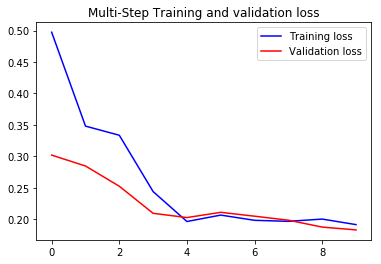

In [42]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

Amazing! Both training and validation loss is constantly decreasing before flattening out! We are definitely not overfitting and one would expect the model to give decent results. Let's see how the predictions are.

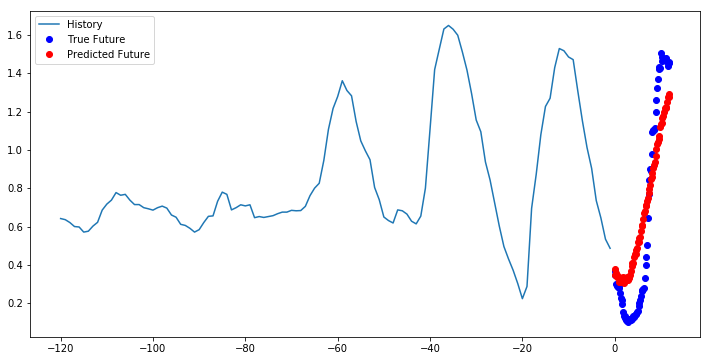

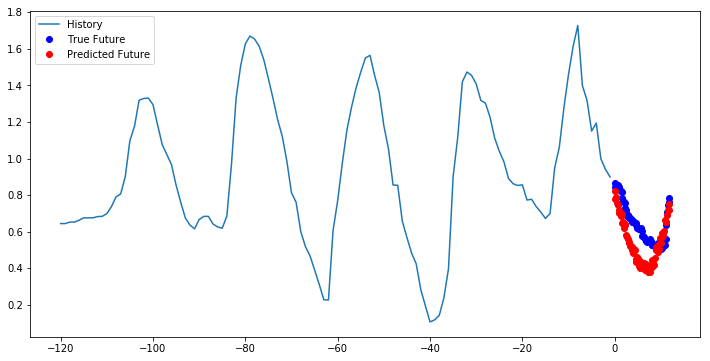

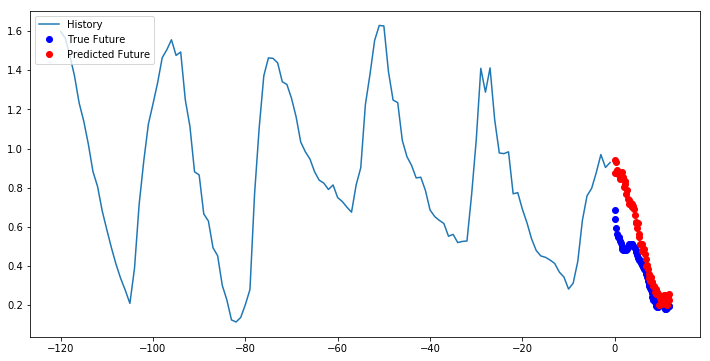

In [43]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Not bad, not bad at all! Infact, I would say that the model has done a very good job at identifying the trend / sesonality in data despite there being not a well defined trend / seasonality in our data. And I guess that's it for now. I am constantly learning / experimenting to find out more about how to optimize RNN's and make my predictions better. Until next time!